In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
tf.__version__

'1.1.0'

# Load datasets

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_input_data = input_data.read_data_sets('./data/tf_data') #, one_hot=True)

Extracting ./data/tf_data/train-images-idx3-ubyte.gz
Extracting ./data/tf_data/train-labels-idx1-ubyte.gz
Extracting ./data/tf_data/t10k-images-idx3-ubyte.gz
Extracting ./data/tf_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_train = mnist_input_data.train
mnist_test = mnist_input_data.test
print("train_len {}, test_len {}".format(mnist_train.num_examples, mnist_test.num_examples))

train_len 55000, test_len 10000


Sample class: 7


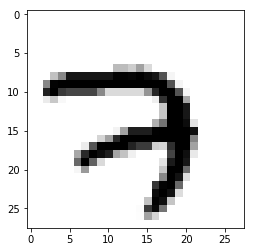

In [5]:
print("Sample class: {}".format(mnist_train.labels[0]))
sample_img = mnist_train.images[0]
sample_img = sample_img.reshape(28,28)
# print("Sample size: {}".format(mnist_train.images[0].size()))
plt.imshow(sample_img).set_cmap('Greys')

# Graph with high level apis: tf.estimator and tf.layers

In [6]:
tf.reset_default_graph()

In [7]:
def model_fn(features, labels, mode):
    x = features['x']
    
    x = tf.reshape(x, [-1, 28, 28, 1])
    
    x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    x = tf.layers.max_pooling2d(inputs=x, pool_size=[2, 2], strides=2)
    
    x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    x = tf.layers.max_pooling2d(inputs=x, pool_size=[2, 2], strides=2)
    
    x = tf.reshape(x, [-1, 7 * 7 * 64]) # flatten 7,7,64 tensor
    
    x = tf.layers.dense(inputs=x, units=1024, activation=tf.nn.relu)
    # dropout layer which is only used in training
    x = tf.layers.dropout(inputs=x, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    y_results = tf.layers.dense(inputs=x, units=10)

    predictions = {
      "classes": tf.argmax(input=y_results, axis=1, name='class_predictor'),
      "probabilities": tf.nn.softmax(y_results, name="classes_softmax_prob")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    else:
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
        #onehot_labels = labels
        loss_op = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=y_results)
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(loss=loss_op, global_step=tf.train.get_global_step(), name='train_op')
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss_op, train_op=train_op)
        else: # EVAL mode
            eval_metric_ops = {
              "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
            }
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss_op, eval_metric_ops=eval_metric_ops)


In [8]:
# test model_fn(PREDICT) manually by running one prediction.
tf.reset_default_graph()
x_ph = tf.placeholder(tf.float32, [None, 784], name='x_ph')
#y_targets_ph = tf.placeholder(tf.float32, [None, 10], name='y_targets_ph')
y_targets_ph = tf.placeholder(tf.float32, [None], name='y_targets_ph')
estimator = model_fn({'x': x_ph}, y_targets_ph, tf.estimator.ModeKeys.PREDICT)
#estimator = model_fn(x_ph, y_targets_ph, tf.estimator.ModeKeys.PREDICT)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

sess.run([estimator[0]], feed_dict={x_ph: np.expand_dims(mnist_test.images[0], 0)})

[{'classes': array([3]),
  'probabilities': array([[ 0.10817411,  0.1061146 ,  0.09063991,  0.1085377 ,  0.10166859,
           0.10352095,  0.09055026,  0.09612758,  0.09685247,  0.09781384]], dtype=float32)}]

In [9]:
# Test model_fn(TRAIN) manually, should return [None]
tf.reset_default_graph()
x_ph = tf.placeholder(tf.float32, [None, 784], name='x_ph')
y_targets_ph = tf.placeholder(tf.float32, [None], name='y_targets_ph')
estimator = model_fn({'x': x_ph}, y_targets_ph, tf.estimator.ModeKeys.TRAIN)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
op = tf.get_default_graph().get_operation_by_name('train_op')
sess.run([op], feed_dict={x_ph: np.expand_dims(mnist_test.images[0], 0),
                                    y_targets_ph: np.expand_dims(mnist_test.labels[0], 0)})

[None]

### Using estimator to train the model

In [10]:
tf.reset_default_graph()

estimator = tf.estimator.Estimator(model_fn=model_fn)

# If you want to monitor more closesly you can start tensorboard with following command
# and then start the browser as tensorboard guides you to
print("tensorboard --logdir {}".format(estimator.model_dir))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
tensorboard --logdir /tmp/tmp6rbr5pnq


In [11]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": mnist_test.images}, y=np.asarray(mnist_test.labels, dtype=np.int32),
    num_epochs=1, shuffle=False)
def test_model_accuracy():
    eval_results = estimator.evaluate(input_fn=eval_input_fn)
    print("Test_model_accuracy: " + str(eval_results))

In [12]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': mnist_train.images}, y=np.asarray(mnist_train.labels, dtype=np.int32),
    batch_size=32, num_epochs=None, shuffle=True)

In [13]:
for epoch in range(4):
    print("Epoch: {}".format(epoch))
    estimator.train(input_fn=train_input_fn, steps=len(mnist_train.images)/32)
    test_model_accuracy()

Epoch: 0
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp6rbr5pnq/model.ckpt.
INFO:tensorflow:loss = 2.2898, step = 1
INFO:tensorflow:global_step/sec: 238.387
INFO:tensorflow:loss = 0.237525, step = 101 (0.420 sec)
INFO:tensorflow:global_step/sec: 301.08
INFO:tensorflow:loss = 0.284098, step = 201 (0.332 sec)
INFO:tensorflow:global_step/sec: 305.159
INFO:tensorflow:loss = 0.0703174, step = 301 (0.328 sec)
INFO:tensorflow:global_step/sec: 279.361
INFO:tensorflow:loss = 0.0426512, step = 401 (0.358 sec)
INFO:tensorflow:global_step/sec: 307.433
INFO:tensorflow:loss = 0.0392076, step = 501 (0.325 sec)
INFO:tensorflow:global_step/sec: 254.823
INFO:tensorflow:loss = 0.0296013, step = 601 (0.392 sec)
INFO:tensorflow:global_step/sec: 310.449
INFO:tensorflow:loss = 0.0166791, step = 701 (0.322 sec)
INFO:tensorflow:global_step/sec: 311.865
INFO:tensorflow:loss = 0.168788, step = 801 (0.321 sec)
INFO:tensorflow:global_step/sec: 316.668
INFO:tensor

INFO:tensorflow:global_step/sec: 302.357
INFO:tensorflow:loss = 0.00146911, step = 5758 (0.331 sec)
INFO:tensorflow:global_step/sec: 308.979
INFO:tensorflow:loss = 0.00373631, step = 5858 (0.324 sec)
INFO:tensorflow:global_step/sec: 316.703
INFO:tensorflow:loss = 0.0126342, step = 5958 (0.316 sec)
INFO:tensorflow:global_step/sec: 317.131
INFO:tensorflow:loss = 5.42686e-05, step = 6058 (0.315 sec)
INFO:tensorflow:global_step/sec: 304.165
INFO:tensorflow:loss = 0.000604316, step = 6158 (0.329 sec)
INFO:tensorflow:global_step/sec: 304.94
INFO:tensorflow:loss = 0.00826757, step = 6258 (0.328 sec)
INFO:tensorflow:global_step/sec: 306.305
INFO:tensorflow:loss = 0.00111393, step = 6358 (0.327 sec)
INFO:tensorflow:global_step/sec: 305.644
INFO:tensorflow:loss = 0.0184049, step = 6458 (0.327 sec)
INFO:tensorflow:global_step/sec: 287.839
INFO:tensorflow:loss = 0.0299011, step = 6558 (0.347 sec)
INFO:tensorflow:global_step/sec: 285.945
INFO:tensorflow:loss = 0.023183, step = 6658 (0.350 sec)
INFO

In [14]:
test_model_accuracy()

INFO:tensorflow:Starting evaluation at 2017-10-05-18:29:32
INFO:tensorflow:Restoring parameters from /tmp/tmp6rbr5pnq/model.ckpt-6876
INFO:tensorflow:Finished evaluation at 2017-10-05-18:29:32
INFO:tensorflow:Saving dict for global step 6876: accuracy = 0.991, global_step = 6876, loss = 0.0282951
Test_model_accuracy: {'accuracy': 0.991, 'loss': 0.028295085, 'global_step': 6876}


There is fancy way to save estimators, load and serve them, but I didn't manage to do that here.

https://www.tensorflow.org/programmers_guide/saved_model#using_savedmodel_with_estimators
